In [108]:
import csv
import numpy as np
from scipy.stats import gmean, gstd
import matplotlib.pyplot as plt

In [109]:
# LOADING
general_path = (
    "/home/matthias/rwth/ba/process-tree-alignments-cpp/remote_res/0/"
)
improvement_path = (
    "/home/matthias/rwth/ba/process-tree-alignments-cpp/remote/8/"
)
# specific_paths = ["BPI_Challenge_2012_pt00/","BPI_Challenge_2012_pt10/","BPI_Challenge_2012_pt25/","BPI_Challenge_2012_pt50/"]
specific_paths = ["BPI_Challenge_2012_pt50/"]
# specific_paths = ["BPI_Challenge_2017_pt00/","BPI_Challenge_2017_pt10/","BPI_Challenge_2017_pt25/","BPI_Challenge_2017_pt50/"]
# specific_paths = specific_paths +  ["BPI_Challenge_2017_pt00/","BPI_Challenge_2017_pt10/","BPI_Challenge_2017_pt25/","BPI_Challenge_2017_pt50/"]
# specific_paths = ["BPI_Challenge_2012_pt10/" , "BPI_Challenge_2017_pt10/"]
base = True 

data = []
spec_data = [[] for _ in range(len(specific_paths))]

for i, specific_path in enumerate(specific_paths):
    path = general_path + specific_path + "costs.csv"
    with open(path, "r", newline="") as file:
        reader = csv.reader(file)
        for row in reader:
            # Ensure the row is not empty and has at least 4 elements
            if row and len(row) >= 4:
                # Take the first 4 elements
                first_two_strings = row[:4]
                try:
                    # Convert the strings to numbers (float or int)
                    # We'll try converting to float, if that fails maybe int
                    
                    first_two_values = [
                        float(val.strip()) if "." in val else int(val.strip())
                        for val in first_two_strings
                    ]
                    first_two_values.append(len(row) - 4)
                    data.append(first_two_values)
                    spec_data[i].append(first_two_values)

                except ValueError as e:
                    print(
                        f"Warning: Could not convert values in row {row[:4]} to numbers. Skipping row. Error: {e}"
                    )
                    # You might want to handle rows with non-numeric values differently
            elif row:
                print(f"Warning: Row has fewer than 4 elements. Skipping row: {row}")



if not base:
    for i, specific_path in enumerate(specific_paths):
        path = improvement_path + specific_path + "costs.csv"
        with open(path, "r", newline="") as file:
            reader = csv.reader(file)
            for count, row in enumerate(reader):
                if row and len(row) >= 2:
                    first_two_strings = row[:2]
                    try:
                        first_two_values = [
                            float(val.strip()) if "." in val else int(val.strip())
                            for val in first_two_strings
                        ]
                        data[1000 * i + count][2] = first_two_values[0]
                        data[1000 * i + count][3] = first_two_values[1]

                        one = data[i][0]
                        two = data[i][1]
                        data[i][0] = data[i][2]
                        data[i][1] = data[i][3]
                        data[i][2] = one
                        data[i][3] = two

                        spec_data[i][count][2] = first_two_values[0]
                        spec_data[i][count][3] = first_two_values[1]
                        
                        one = spec_data[i][count][0]
                        two = spec_data[i][count][1]
                        spec_data[i][count][0] = spec_data[i][count][2]
                        spec_data[i][count][1] = spec_data[i][count][3]
                        spec_data[i][count][2] = one
                        spec_data[i][count][3] = two

                    except ValueError as e:
                        print(
                            f"Warning: Could not convert values in row {row[:4]} to numbers. Skipping row. Error: {e}"
                        )
                        # You might want to handle rows with non-numeric values differently
                elif row:
                    print(f"Warning: Row has fewer than 4 elements. Skipping row: {row}")



In [110]:
# PERFORMANCE FACTORS

performance_factors = []
py_exec = 0 
cpp_exec = 0
py_slow = 0
cpp_slow = 0
# for val in spec_data[3]:
for val in data:
    if val[0] != -1 and val[2] != -1:
        if val[0] != val[2]:
            print(val)
            
        performance_factors.append(val[3] / val[1])

        # if val[3] / val[1] < 2:
        #     print(val)
        py_exec += val[3]
        cpp_exec += val[1]
    else:
        if val[0] == -1:
            cpp_slow += 1
        if val[2] == -1:
            py_slow += 1
# print(len([x for x in performance_factors if x >= 1]))    
print(len(performance_factors))

989


In [111]:
# PERFORMANCE FACTORS
valid_executions = len(performance_factors)
geo_mean = gmean(performance_factors)
print(f"Geometric mean performance factor: {geo_mean:.3f}")

# Calculate and print geometric standard deviation (sample), rounded to 3 decimal places
geo_std = gstd(performance_factors, ddof=1)
print(f"Geometric standard deviation performance factors: {geo_std:.3f}")

# Round average python runtime to 3 decimal places
print(f"average python runtime: {py_exec / valid_executions:.3f}")
# Round average c++ runtime to 3 decimal places
print(f"average c++ runtime: {cpp_exec / valid_executions:.3f}")
print(f"c++ timeouts: {cpp_slow}")
print(f"py timeouts: {py_slow}")

# Min performance factor doesn't need rounding unless it's a float display issue
print(f"min performance factor: {min(performance_factors):.3f}")

Geometric mean performance factor: 3.874
Geometric standard deviation performance factors: 1.702
average python runtime: 4.263
average c++ runtime: 1.971
c++ timeouts: 8
py timeouts: 11
min performance factor: 1.562


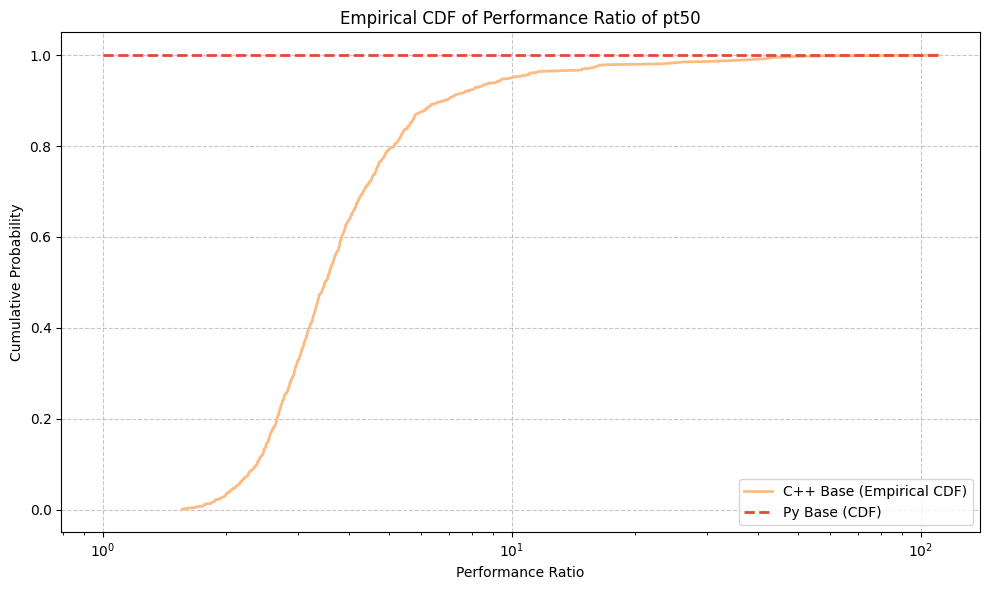

In [112]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
colors = ["#fdbb84", "#e34a33"]
# color = ["red,blue"]

sorted_performance_factors_cpp = np.sort(performance_factors)
y_cdf_cpp = np.arange(1, len(sorted_performance_factors_cpp) + 1) / len(sorted_performance_factors_cpp)

y_cdf_py_base = np.where(sorted_performance_factors_cpp < 1.0, 0.0, 1.0)

plt.plot(sorted_performance_factors_cpp, y_cdf_cpp, color=colors[0], linewidth=2, label="C++ Base (Empirical CDF)")

py_x = []
py_y = []
has_one = False
for i, x_val in enumerate(sorted_performance_factors_cpp):
    if x_val < 1.0:
        py_x.append(x_val)
        py_y.append(0.0)
    elif x_val >= 1.0 and not has_one:
        # Add a point just before 1.0 at y=0, then at 1.0 at y=1 to create the step
        if py_x and py_x[-1] < 1.0: # Ensure we don't duplicate if already added
             py_x.append(1.0 - 1e-9) # A tiny bit less than 1
             py_y.append(0.0)
        py_x.append(1.0)
        py_y.append(1.0)
        has_one = True # Mark that we've crossed the 1.0 threshold
    elif x_val > 1.0:
        py_x.append(x_val)
        py_y.append(1.0)

# Handle the case where all performance factors are >= 1.0
if not has_one and len(sorted_performance_factors_cpp) > 0 and sorted_performance_factors_cpp[0] >= 1.0:
    py_x.append(0.0) # Start from 0 for values less than 1.0 (conceptual)
    py_y.append(0.0)
    py_x.append(1.0)
    py_y.append(1.0)
    for x_val in sorted_performance_factors_cpp:
        if x_val >= 1.0:
            py_x.append(x_val)
            py_y.append(1.0)

plt.plot(py_x, py_y, color=colors[1], linewidth=2, linestyle='--', label="Py Base (CDF)")


# --- Set scales ---
plt.yscale('linear') # CDFs are always linear on Y
plt.xscale('log') # X-axis can be log if performance ratios vary widely

# Add labels and styling
plt.xlabel("Performance Ratio")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Performance Ratio of pt50")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_26509/3746303730.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 10 ** 2)


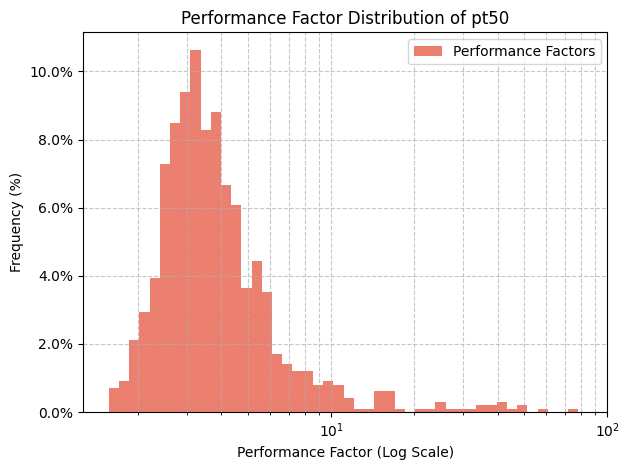

In [117]:
from matplotlib.ticker import PercentFormatter # MODIFICATION 1: Import the formatter
number_of_bins = 50
graphs = [performance_factors]
colors = ["#e34a33"]
names = ['Performance Factors']
# ---------------------------------------------------


# --- Calculate logarithmically spaced bins ---
# Find the range of the data
min_val = np.min(performance_factors)
max_val = np.max(performance_factors)

# Log scales require positive values. Check if min_val is positive.
if min_val <= 0:
    print(f"Warning: Data contains non-positive values (minimum: {min_val}). "
          "Filtering data to be > 0 for plotting.")
    performance_factors = performance_factors[performance_factors > 0]
    if len(performance_factors) == 0:
        print("Error: No positive data points found after filtering.")
        exit()

    min_val = np.min(performance_factors)
    max_val = np.max(performance_factors)
    graphs = [performance_factors]

# Ensure min_val is still positive after potential filtering
if min_val > 0:
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)
    log_bins = np.logspace(log_min, log_max, number_of_bins + 1)
else:
    print("Error: Minimum data value is not positive. Cannot create log bins.")
    log_bins = number_of_bins

# Create histograms for each data set
for i, content in enumerate(graphs):
    # MODIFICATION 2: Create weights to normalize the histogram to 1
    weights = np.ones_like(content, dtype=float) / len(content)
    
    # MODIFICATION 3: Use the 'weights' parameter instead of 'density'
    plt.hist(content, bins=log_bins, color=colors[i % len(colors)], alpha=0.7, label=names[i], weights=weights)

# --- Set the X-axis scale to logarithmic ---
plt.xscale('log')
plt.xlim(0, 10 ** 2)

# --- MODIFICATION 4: Format the Y-axis to show percentages ---
# PercentFormatter(1.0) treats a value of 1.0 on the axis as 100%.
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Add labels and styling
plt.xlabel("Performance Factor (Log Scale)")
plt.ylabel("Frequency (%)") # Update Y-axis label
plt.title("Performance Factor Distribution of pt50")
plt.grid(True, linestyle="--", alpha=0.7, which="both")
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()



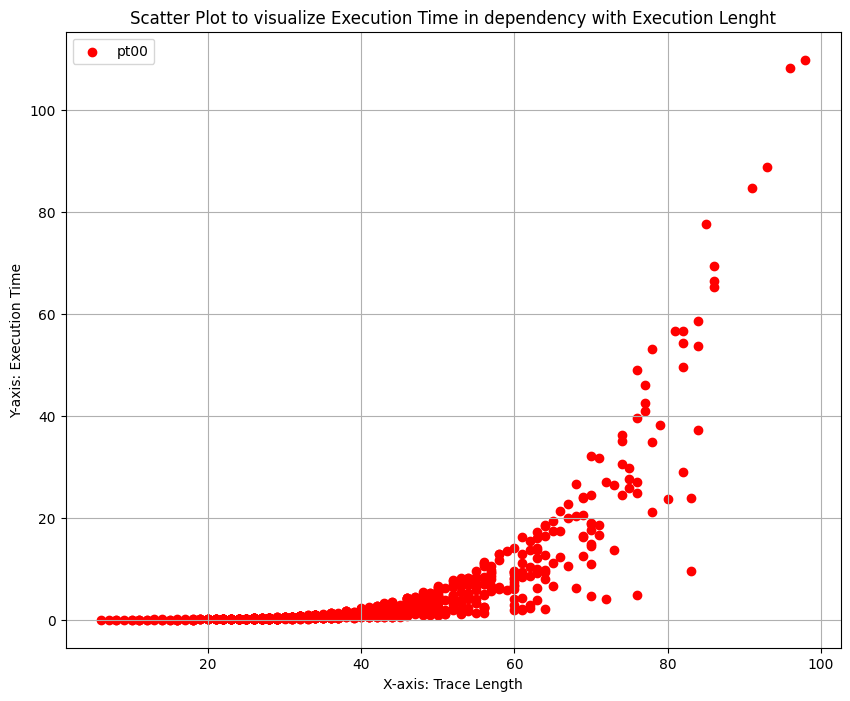

In [114]:
plt.figure(figsize=(10, 8)) # Optional: set a larger figure size for multiple datasets

# Generate a list of distinct colors
colors = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta"]
# colors = ["red", "blue", "green", "yellow"]
names = ["pt00", "pt10", "pt25", "pt50", "new_pt1", "new_pt2", "new_pt3", "new_pt4"]
# names = ["pt00", "pt10", "pt25", "pt50"]


for i, specific_data in enumerate(spec_data):
    graph_data = [[x[-1], x[3]] for x in specific_data if x[2] != -1]
    graph_data.sort(key=lambda x: x[0])

    x_values = [point[0] for point in graph_data]
    y_values = [point[1] for point in graph_data]

    plt.scatter(x_values, y_values, color=colors[i], label=names[i])
# graph_data = [[x[-1], x[3]/x[1]] for x in data if x[2] != -1]

# Add labels and title for clarity
plt.xlabel("X-axis: Trace Length")
plt.ylabel("Y-axis: Execution Time")
plt.title("Scatter Plot to visualize Execution Time in dependency with Execution Lenght")

# Add a grid (optional, but often helpful)
plt.grid(True)

# Add a legend to distinguish between datasets
plt.legend()

# Show the plot
plt.show()



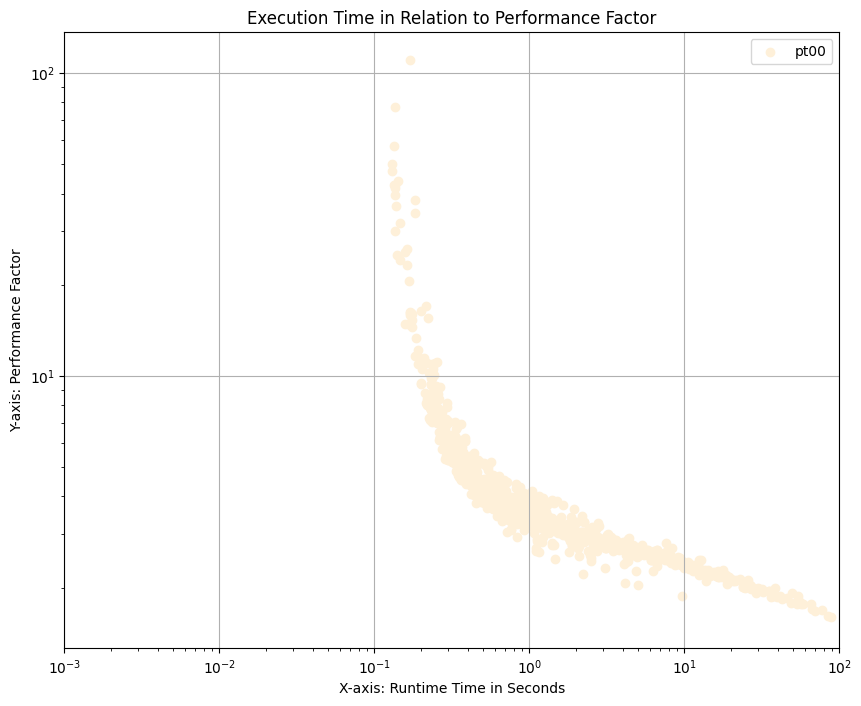

In [115]:
plt.figure(figsize=(10, 8))

colors = ["#fef0d9", "#fdcc8a", "#fc8d59", "#d7301f"]
names = ["pt00", "pt10", "pt25", "pt50"]

for i, specific_data in enumerate(spec_data):
    graph_data = [[x[3], x[3]/x[1]] for x in specific_data if x[2] != -1]
    graph_data.sort(key=lambda x: x[0])

    x_values = [point[0] for point in graph_data]
    y_values = [point[1] for point in graph_data]

    plt.scatter(x_values, y_values, color=colors[i], label=names[i])

# Set the x-axis limits to always be from 10^-3 to 10^-2
plt.xlim(10 ** -3, 10 ** 2)

# Add labels and title for clarity
plt.ylabel("Y-axis: Performance Factor")
plt.xlabel("X-axis: Runtime Time in Seconds")
plt.xscale('log')
plt.yscale('log')
plt.title("Execution Time in Relation to Performance Factor")

# Add a grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



<Figure size 1000x800 with 0 Axes>

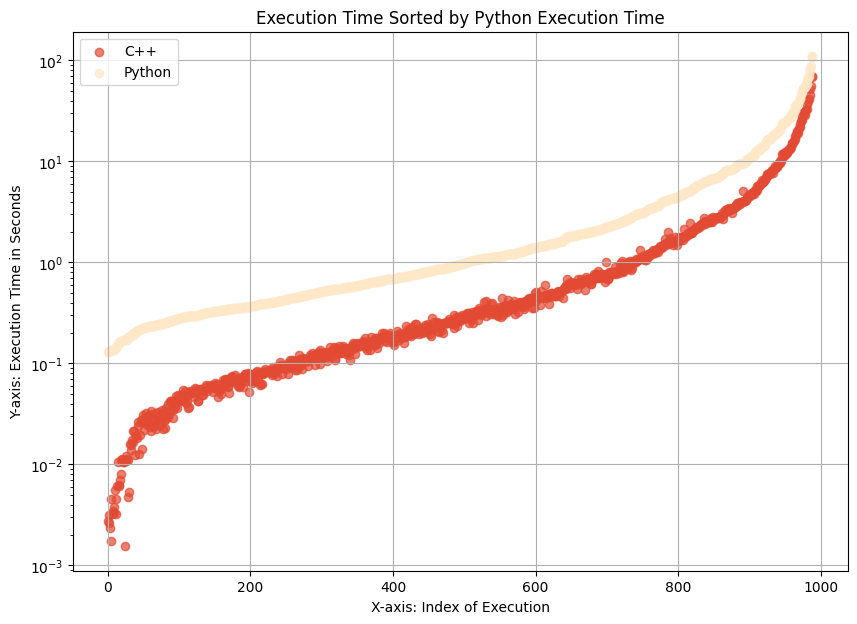

In [116]:
plt.figure(figsize=(10, 8)) # Optional: set a larger figure size for multiple datasets

# Generate a list of distinct colors

cpp_data = [x[1] for x in data if x[2] != -1]
py_data = [x[3] for x in data if x[2] != -1]
# cpp_data = [x[1] for x in spec_data[0] if x[2] != -1]
# py_data = [x[3] for x in spec_data[0]  if x[2] != -1]

combined_data = list(zip(py_data, cpp_data))
combined_data.sort(key=lambda item: item[0])

py_data = [item[0] for item in combined_data]
cpp_data = [item[1] for item in combined_data]


x_axis = [i for i in range(len(cpp_data))]

# cpp_data.sort()
# py_data.sort()


plt.figure(figsize=(10, 7))

plt.scatter(x_axis, cpp_data, color='#e34a33', alpha=0.7, label='C++')
plt.scatter(x_axis, py_data, color='#fee8c8', alpha=0.7, label='Python')

# plt.scatter(x_values, y_values, color=colors[i], label=names[i])

# Add labels and title for clarity
plt.ylabel("Y-axis: Execution Time in Seconds")
plt.xlabel("X-axis: Index of Execution")
plt.title("Execution Time Sorted by Python Execution Time")
# plt.xscale('log')
plt.yscale('log')

# Add a grid (optional, but often helpful)
plt.grid(True)

# Add a legend to distinguish between datasets
plt.legend()

# Show the plot
plt.show()

